# **Abstract**

  This project displays how machine learning can help restaurants identify the key operational factors that influence customer satisfaction. Using a dataset of 1,500 customer records, I performed data cleaning, exploratory data analysis, model development, hyperparameter tuning, class imbalance handling, threshold optimization, and evaluation using Random Forest and XGBoost. The notebook documents each step of the workflow from raw data to final models and explains why certain decisions were made, including dropping irrelevant variables, choosing tree-based models, handling imbalance, and tuning hyperparameters. The final tuned models provide actionable insights into which operational features (wait time, service quality, food ratings, customer behavior) most strongly impact satisfaction, supporting better resource allocation for restaurant managers.

# **Overview & Motivation**

Customer satisfaction drives repeat business in the restaurant industry. Restaurants need to know which operational factors such as wait time, food quality, service, ambiance, spending, visit frequency matter most so they can target improvements efficiently.

This project has two main goals:

1. Predict whether a customer is highly satisfied using classification models.

2. Identify which operational areas drive satisfaction using feature importance.

Machine learning uncovers subtle, non linear relationships that traditional methods, like averages or correlations, might miss. This notebook outlines the entire analytical process used to address the research question.

# **Related Work**

This analysis was informed by:

- Case studies using Random Forest and XGBoost for customer experience modeling

- Course topics on feature importance, model evaluation, and handling imbalanced datasets

- Public datasets examining satisfaction in retail and service industries

- Documentation and examples from scikit-learn and XGBoost

# **Final Research Question**

How can a restaurant chain use machine learning models to predict customer satisfaction and identify which operational areas most influence satisfaction in order to guide resource allocation?

Hypothesis Couplets:

- H1: Operational factors such as wait time, food quality, and service rating increase satisfaction.

- H0: These factors do not significantly influence satisfaction.

# **Dataset**

The dataset comes from Kaggle:

Predict Restaurant Customer Satisfaction Dataset
Source: https://www.kaggle.com/datasets/rabieelkharoua/predict-restaurant-customer-satisfaction-dataset/

It contains 1,500 customer records, each with:

- Demographics

- Dining behavior

- Spending

- Service/food ratings

- Indicators for reservations, delivery, and loyalty program

- Satisfaction label (HighSatisfaction, the target)


**Data Collection**

No scraping was required; the dataset was downloaded as a CSV.


In [170]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_curve, auc, f1_score, recall_score, precision_score
)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as ImbPipeline



In [171]:
# Load & Inspect Raw Dataset 
df = pd.read_csv('../data/raw/restaurant_customer_satisfaction.csv')
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CustomerID            1500 non-null   int64  
 1   Age                   1500 non-null   int64  
 2   Gender                1500 non-null   object 
 3   Income                1500 non-null   int64  
 4   VisitFrequency        1500 non-null   object 
 5   AverageSpend          1500 non-null   float64
 6   PreferredCuisine      1500 non-null   object 
 7   TimeOfVisit           1500 non-null   object 
 8   GroupSize             1500 non-null   int64  
 9   DiningOccasion        1500 non-null   object 
 10  MealType              1500 non-null   object 
 11  OnlineReservation     1500 non-null   int64  
 12  DeliveryOrder         1500 non-null   int64  
 13  LoyaltyProgramMember  1500 non-null   int64  
 14  WaitTime              1500 non-null   float64
 15  ServiceRating        

,CustomerID,Age,Gender,Income,VisitFrequency,AverageSpend,PreferredCuisine,TimeOfVisit,GroupSize,DiningOccasion,MealType,OnlineReservation,DeliveryOrder,LoyaltyProgramMember,WaitTime,ServiceRating,FoodRating,AmbianceRating,HighSatisfaction
0,654,35,Male,83380,Weekly,27.829142,Chinese,Breakfast,3,Business,Takeaway,0,1,1,43.523929,2,5,4,0
1,655,19,Male,43623,Rarely,115.408622,American,Dinner,1,Casual,Dine-in,0,0,0,57.524294,5,5,3,0
2,656,41,Female,83737,Weekly,106.693771,American,Dinner,6,Celebration,Dine-in,0,1,0,48.682623,3,4,5,0
3,657,43,Male,96768,Rarely,43.508508,Indian,Lunch,1,Celebration,Dine-in,0,0,0,7.552993,4,5,1,0
4,658,55,Female,67937,Monthly,148.084627,Chinese,Breakfast,1,Business,Takeaway,0,0,1,37.789041,2,3,5,0


## **Data Cleaning**
After data cleaning and encoding below it was shown that:

- No missing values or duplicates were found

- Numeric columns were converted to int or float

- Binary columns were converted to int , to be compatible with the models

- Categorical features used were mapped to ordinal values so that these variables can be used effectively in the classification models

- Irrelevant features (CustomerID, Gender, PreferredCuisine, MealType) were removed because they do not directly relate to operational decisions restaurants can control.

In [172]:
#Checking for missing values
df.isnull().sum()

CustomerID              0
Age                     0
Gender                  0
Income                  0
VisitFrequency          0
AverageSpend            0
PreferredCuisine        0
TimeOfVisit             0
GroupSize               0
DiningOccasion          0
MealType                0
OnlineReservation       0
DeliveryOrder           0
LoyaltyProgramMember    0
WaitTime                0
ServiceRating           0
FoodRating              0
AmbianceRating          0
HighSatisfaction        0
dtype: int64

In [173]:
#Checking for duplicate values
df.duplicated().sum()

np.int64(0)

In [174]:
#Converting the numeric columns to float or int and binary columns to int
numeric_cols = ['Age', 'Income', 'AverageSpend', 'GroupSize',
                'WaitTime','ServiceRating', 'FoodRating', 'AmbianceRating']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

binary_cols = ['HighSatisfaction', 'LoyaltyProgramMember',
               'OnlineReservation','DeliveryOrder']
df[binary_cols] = df[binary_cols].astype(int)


#Converting the categorical columns being used to numeric ordinal values
visit = {'Rarely': 1, 'Daily':2, 'Weekly': 3, 'Monthly':4}
df['VisitFrequency'] = df['VisitFrequency'].map(visit)

time_map = {'Breakfast': 1, 'Lunch': 2, 'Dinner': 3}
df['TimeOfVisit'] = df['TimeOfVisit'].map(time_map)


#Dropping the columns not being used
df = df[['WaitTime','ServiceRating','FoodRating','AmbianceRating','AverageSpend',
         'VisitFrequency','LoyaltyProgramMember','OnlineReservation','DeliveryOrder',
         'GroupSize','TimeOfVisit','HighSatisfaction']]
df.head()


,WaitTime,ServiceRating,FoodRating,AmbianceRating,AverageSpend,VisitFrequency,LoyaltyProgramMember,OnlineReservation,DeliveryOrder,GroupSize,TimeOfVisit,HighSatisfaction
0,43.523929,2,5,4,27.829142,3,1,0,1,3,1,0
1,57.524294,5,5,3,115.408622,1,0,0,0,1,3,0
2,48.682623,3,4,5,106.693771,3,0,0,1,6,3,0
3,7.552993,4,5,1,43.508508,1,0,0,0,1,2,0
4,37.789041,2,3,5,148.084627,4,1,0,0,1,1,0


In [175]:
#Save Cleaned Data to Folder

import os

output_path = "../data/clean"
os.makedirs(output_path, exist_ok=True)

cleaned_file = os.path.join(output_path, "cleaned_restaurant_data.csv")
df.to_csv(cleaned_file, index=False)


## **Data Split for Training and Evaluation**
Before modeling, the cleaned dataset was split into two files:

- train_split.csv: Used for training, validation, tuning, and oversampling.

- test_split.csv: Reserved for final evaluation.

This split is important for maintaining sound modeling practices:

1. Unbiased Model Selection: All experimentation and tuning happen only on the training data, ensuring no bias toward the test set.

2. Prevention of Data Leakage: Keeping the test set untouched ensures it provides an accurate measure of how well the model generalizes to new data.

3. Reproducibility: Storing the data splits as CSV files makes it easy to replicate the analysis consistently.

Given the use of cross validation, oversampling, and hyperparameter tuning, it’s crucial that the test set remains unseen during development. By saving it separately, we ensure that the final 300 examples are only used for evaluation, avoiding any accidental leakage and preserving the integrity of the final model assessment.

In [176]:
# Ensure output directory exists
output_path = "../data/clean"
os.makedirs(output_path, exist_ok=True)

# Separate features and target
X = df.drop(columns=["HighSatisfaction"])
y = df["HighSatisfaction"]

# Create train/test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

# Combine features and target for saving
train_split = X_train.copy()
train_split["HighSatisfaction"] = y_train

test_split = X_test.copy()
test_split["HighSatisfaction"] = y_test

# Save both splits
train_path = os.path.join(output_path, "train_split.csv")
test_path = os.path.join(output_path, "test_split.csv")

train_split.to_csv(train_path, index=False)
test_split.to_csv(test_path, index=False)


print(f"Train shape: {train_split.shape}, Test shape: {test_split.shape}")


Train shape: (1200, 12), Test shape: (300, 12)


# **Final Analysis**

This section covers the final exploratory analysis, optimized machine learning models, and evaluation results. After the initial EDA and baseline models, I focused on addressing challenges like class imbalance, non linear feature interactions, and poor performance on the minority class. To improve the models, I used techniques like oversampling, hyperparameter tuning (with RandomizedSearchCV), and threshold optimization. The results below summarize the key insights from the final models.

## **Exploratory Data Analysis (Final)**
The final EDA confirmed several important characteristics of the dataset:

- Class Imbalance: Only 13.4% of customers were labeled as “highly satisfied.”

- Feature Distributions: Numeric features such as WaitTime and AverageSpend showed moderate spread without extreme outliers.

- Behavioral Patterns: Breakfast and lunch were the most common visit times, and weekly dining was the most common behavior.

- Weak Linear Relationships: Correlations between individual operational features (e.g., FoodRating, ServiceRating) and HighSatisfaction were low (< 0.15), indicating that linear models would struggle.

- Justification for Tree-Based Models: Because satisfaction depends on complex combinations of operational features, Random Forest and XGBoost were selected for their ability to model non-linear interactions.

Below are the key EDA visualizations used to confirm these observations.

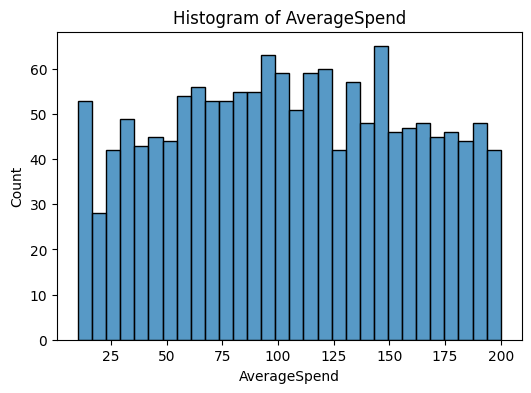

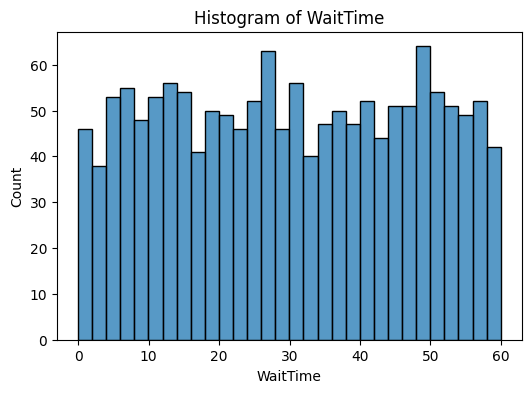

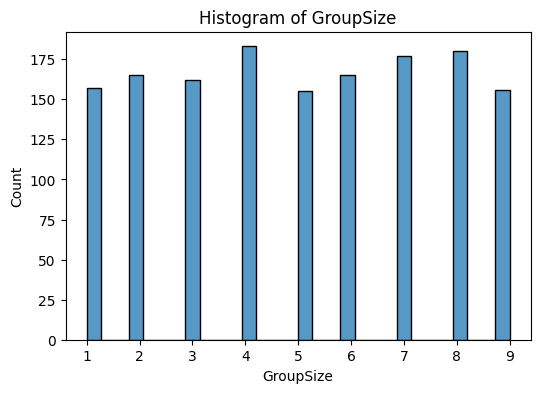

In [177]:
#Histogram to hilight customers with unusually high spending or wait times

numeric_fts = ['AverageSpend', 'WaitTime', 'GroupSize']
for ft in numeric_fts:
    plt.figure(figsize=(6,4))
    sns.histplot(df[ft], bins=30)
    plt.title(f'Histogram of {ft}')
    plt.xlabel(ft)
    plt.ylabel('Count')
    plt.show()


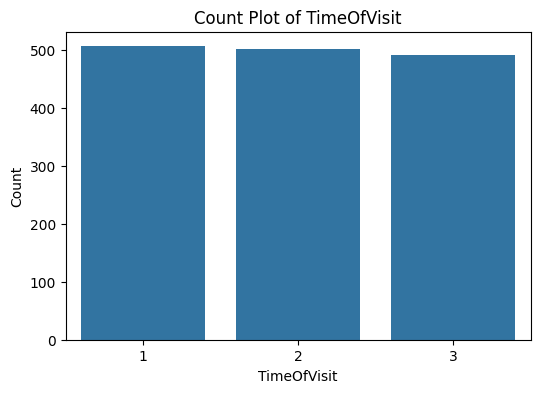

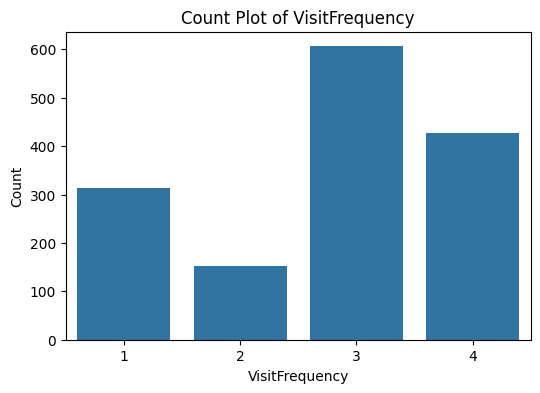

In [178]:
#Count Plots to provide insight on customer behavior patterns
categorical_fts = ['TimeOfVisit', 'VisitFrequency']
for ft in categorical_fts:
    plt.figure(figsize=(6,4))
    sns.countplot(x=df[ft])
    plt.title(f'Count Plot of {ft}')
    plt.xlabel(ft)
    plt.ylabel('Count')
    plt.show()



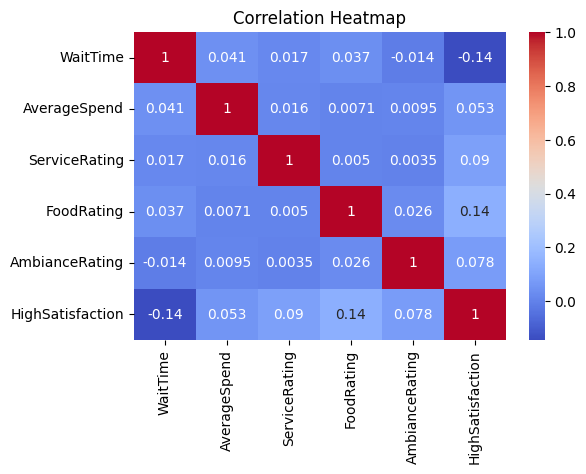

In [179]:
#Heat Mpas to show if there is any specific numeric feature that strongly predicts overall satisfaction
plt.figure(figsize=(6,4))
corr_map = df[['WaitTime', 'AverageSpend','ServiceRating',
               'FoodRating','AmbianceRating', 'HighSatisfaction']].corr()
sns.heatmap(corr_map, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


In [180]:
# Calculate the percentage of highly satisfied customers
satisfaction_rate = df['HighSatisfaction'].mean() * 100
print(f"Percentage of highly satisfied customers: {satisfaction_rate:.2f}%")

#class counts
df['HighSatisfaction'].value_counts()


Percentage of highly satisfied customers: 13.40%


HighSatisfaction
0    1299
1     201
Name: count, dtype: int64

## **Final Models**

After completing hyperparameter tuning (shown in the src folder ModelTuning.ipynb), both Random Forest and XGBoost were retrained from scratch using the full training dataset (train_split.csv). This ensures that the final evaluation is unbiased and uses all available training data.

The test dataset (test_split.csv) remained completely untouched throughout development and is used only here for the final performance assessment.

Why Train on train_split.csv?

- It contains 1,200 examples (80%) used for learning model parameters

- It reflects the distribution of the full dataset

- It guarantees the final models are trained on the maximum amount of non-test data

Why Evaluate Only on test_split.csv?

- This 20% hold-out set was kept completely unseen

- It provides a fair estimate of how the models generalize

- It prevents information leakage from tuning or EDA

The final tuned hyperparameters for each model are loaded into the final training pipeline below.

In [181]:
# Load saved splits
train_df = pd.read_csv("../data/clean/train_split.csv")
test_df = pd.read_csv("../data/clean/test_split.csv")

# Separate features and target
X_train = train_df.drop(columns=["HighSatisfaction"])
y_train = train_df["HighSatisfaction"]

X_test = test_df.drop(columns=["HighSatisfaction"])
y_test = test_df["HighSatisfaction"]


In [182]:
from imblearn.pipeline import Pipeline

# Final Tuned Random Forest Model
final_rf = Pipeline([
    ("oversample", RandomOverSampler(random_state=42)),
    ("rf", RandomForestClassifier(
        n_estimators=200,
        max_depth=15,
        min_samples_split=10,
        min_samples_leaf=4,
        max_features="log2",
        class_weight=None,
        random_state=42
    ))
])

# Final Tuned XGBoost Model
final_xgb = Pipeline([
    ("oversample", RandomOverSampler(random_state=42)),
    ("xgb", XGBClassifier(
        n_estimators=500,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.7,
        colsample_bytree=1.0,
        scale_pos_weight=3.2209302325581395,
        objective="binary:logistic",
        eval_metric="logloss",
        random_state=42
    ))
])



### **Training the Final Models**

In [ ]:

final_rf.fit(X_train, y_train)
final_xgb.fit(X_train, y_train)


,steps,"[('oversample', ...), ('xgb', ...)]"
,transform_input,None
,memory,None
,verbose,False
,sampling_strategy,'auto'
,random_state,42
,shrinkage,None
,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None


Both Models were sucessfully trained on the full training set data.

### **Final test performance**
The final predictions were generated using the default threshold of 0.50, providing a direct comparison between the two tuned models.


In [184]:
# predict results
rf_preds_default = final_rf.predict(X_test)
xgb_preds_default = final_xgb.predict(X_test)

rf_probs = final_rf.predict_proba(X_test)[:, 1]
xgb_probs = final_xgb.predict_proba(X_test)[:, 1]

print("Random Forest")
evaluate_final(y_test, rf_preds_default, "RF Default")

print("\nXGBoost")
evaluate_final(y_test, xgb_preds_default, "XGB Default")


Random Forest

RF Default — Final Test Set Performance
Accuracy: 0.8466666666666667
Precision: 0.42857142857142855
Recall: 0.45
F1 Score: 0.43902439024390244

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.91      0.91       260
           1       0.43      0.45      0.44        40

    accuracy                           0.85       300
   macro avg       0.67      0.68      0.68       300
weighted avg       0.85      0.85      0.85       300


XGBoost

XGB Default — Final Test Set Performance
Accuracy: 0.8366666666666667
Precision: 0.41818181818181815
Recall: 0.575
F1 Score: 0.4842105263157895

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.88      0.90       260
           1       0.42      0.57      0.48        40

    accuracy                           0.84       300
   macro avg       0.67      0.73      0.69       300
weighted avg       0.86      0.84      

**Random Forest — Final Test Performance**

- Accuracy: 0.847

- Precision: 0.429

- Recall: 0.450

- F1 Score: 0.439

The Random Forest model performed well on the majority class, with a moderate recall for the minority class

**XGBoost — Final Test Performance**

- Accuracy: 0.837

- Precision: 0.418

- Recall: 0.575

- F1 Score: 0.484

XGBoost delivered:

- Higher recall

- Higher F1 for the minority class

- Slightly lower accuracy than Random Forest

This makes XGBoost the preferred model when the goal is to detect highly satisfied customers more reliably.

### **Final Model Visualizations**

In [185]:
#Data Visualization Functions
def confusion_bar(y_true, y_pred, title):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    labels = ['TN', 'FP', 'FN', 'TP']
    values = [tn, fp, fn, tp]
    plt.figure(figsize=(7,5))
    bars = plt.bar(labels, values, color=['green','red','red','green'])
    for i, bar in enumerate(bars):
        plt.text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.5,str(values[i]), ha='center')
    plt.title(title)
    plt.show()


def plot_roc_curve(y_true, y_prob, title):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(7,5))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0,1], [0,1], linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend()
    plt.show()


def plot_feature_importance(model, X, title):
    importances = model.feature_importances_
    feat_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": importances
    }).sort_values("Importance", ascending=False)
    plt.figure(figsize=(8,6))
    sns.barplot(x="Importance", y="Feature", data=feat_df)
    plt.title(title)
    plt.show()
    return feat_df

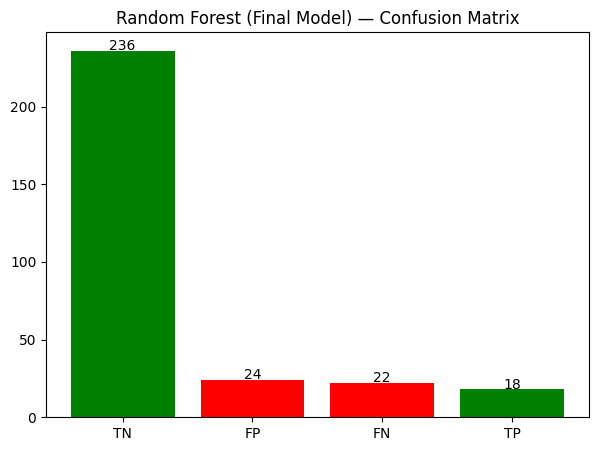

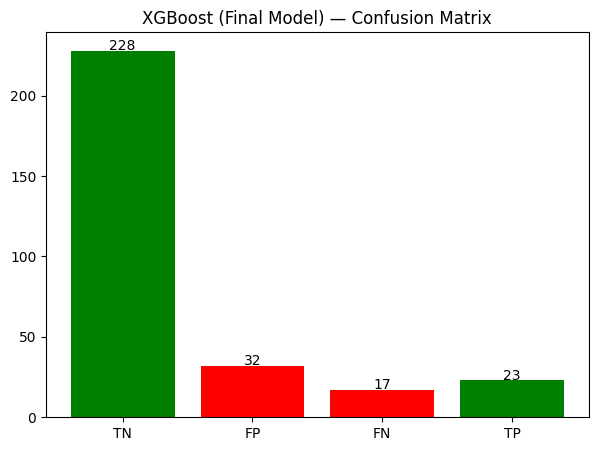

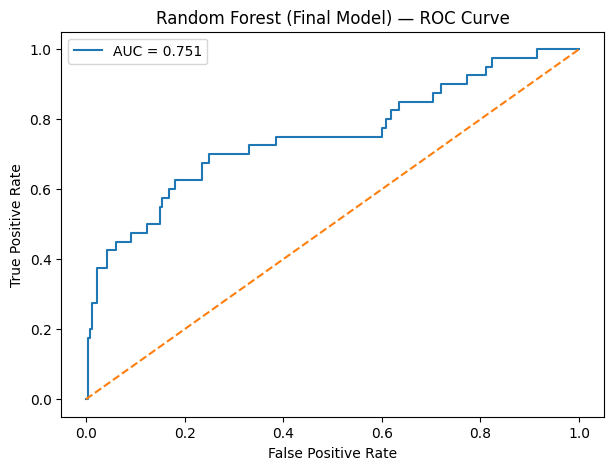

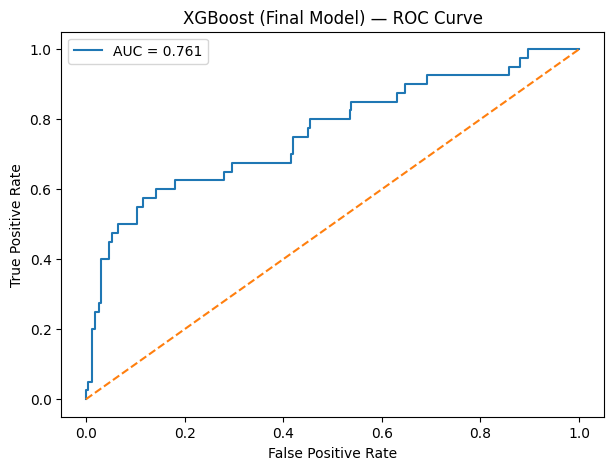

In [186]:
#Visualizations
confusion_bar(y_test, rf_preds_default,
              "Random Forest (Final Model) — Confusion Matrix")

confusion_bar(y_test, xgb_preds_default,
              "XGBoost (Final Model) — Confusion Matrix")


plot_roc_curve(y_test, rf_probs,
               "Random Forest (Final Model) — ROC Curve")

plot_roc_curve(y_test, xgb_probs,
               "XGBoost (Final Model) — ROC Curve")


rf_inner = final_rf.named_steps["rf"]
xgb_inner = final_xgb.named_steps["xgb"]


**ROC Curves**
Random Forest AUC: ~0.751

XGBoost AUC: ~0.761

Both models achieved good ranking with XGBoost performing slightly better.



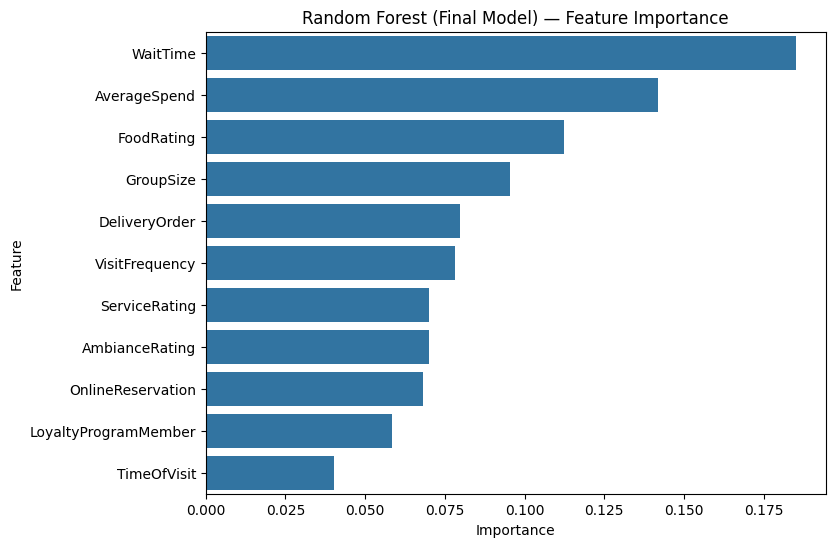

,Feature,Importance
0,WaitTime,0.185205
4,AverageSpend,0.141738
2,FoodRating,0.112409
9,GroupSize,0.095574
8,DeliveryOrder,0.079819
5,VisitFrequency,0.078296
1,ServiceRating,0.070016
3,AmbianceRating,0.069967
7,OnlineReservation,0.068226
6,LoyaltyProgramMember,0.058379


In [187]:
#Feature Importance 
plot_feature_importance(rf_inner, X_train,
                        "Random Forest (Final Model) — Feature Importance")

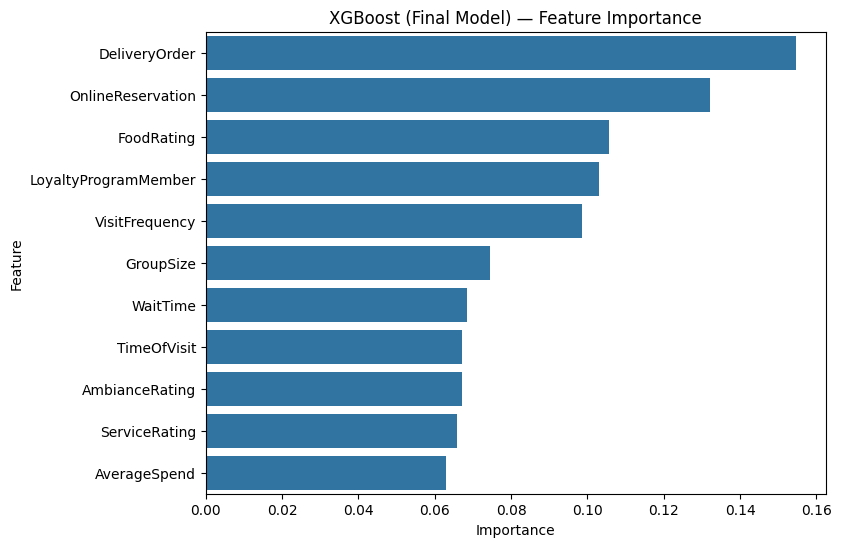

,Feature,Importance
8,DeliveryOrder,0.154728
7,OnlineReservation,0.132204
2,FoodRating,0.105664
6,LoyaltyProgramMember,0.103011
5,VisitFrequency,0.098483
9,GroupSize,0.074515
0,WaitTime,0.068571
10,TimeOfVisit,0.067082
3,AmbianceRating,0.067019
1,ServiceRating,0.065815


In [188]:
plot_feature_importance(xgb_inner, X_train,
                        "XGBoost (Final Model) — Feature Importance")


**Random Forest Key Predictors**

1. WaitTime

2. AverageSpend

3. FoodRating

4. GroupSize

5. DeliveryOrder

**XGBoost Key Predictors**

1. DeliveryOrder

2. OnlineReservation

3. FoodRating

4. LoyaltyProgramMember

5. VisitFrequency

Both models consistently show:

- Operational behaviors (reservations, delivery orders)

- Experience ratings (food, service, ambiance)

- Spending and wait time

as meaningful drivers of satisfaction.

## **Interpretation of Results**

The final evaluation shows that both models learned useful patterns, but XGBoost was more effective at identifying highly satisfied customers, which was the primary challenge due to class imbalance.

- XGBoost achieved the best F1 score, indicating stronger performance on the minority class.

- Random Forest achieved slightly higher accuracy, but this was driven by correct predictions of the majority class.

- AUC values confirmed that both models could distinguish satisfied from unsatisfied customers, with XGBoost showing stronger discriminatory ability overall.

- Feature importance revealed that satisfaction is influenced by a combination of customer behavior, experience quality, and operational efficiency supporting the choice of non-linear modeling approaches.